# Пункт 1. Реализовать стохастический градиентный спуск

In [89]:
import numpy as np
from math import *
import matplotlib.pyplot as plt
from numpy import linalg as LA

In [90]:
DEFAULT_LR = 0.01

In [91]:
# linear function, computes k-th coordinate by k-1 first
#   coefficients - k-1-dim array
#   x - k-1-dim array
def f(coefficients, x, coefficient_bound = 0):
    return np.sum(coefficients * x) + coefficient_bound * (2 * np.random.random_sample() - 1)

# scale coord array into [0; 1] interval
def scale_dim(coords):
    mn = coords[0]
    mx = coords[0]
    for i in range(0, len(coords)):
        mn = min(mn, coords[i])
        mx = max(mx, coords[i])
    if mn == mx:
        for i in range(0, len(coords)):
            coords[i] = 0
    else:
        for i in range(0, len(coords)):
            coords[i] = (coords[i] - mn) / (mx - mn)
    return [coords, mn, mx]

# scale all point_set coords into [0; 1] interval
def apply_scaling(points):
    x = points.x.copy()
    y = points.y.copy()
    for k in range(0, points.dim - 1):
        coords = np.asarray([])
        for i in range(0, points.n):
            coords = np.append(coords, points.x[i][k])
        coords = scale_dim(coords)[0]
        for i in range(0, points.n):
            x[i][k] = coords[i]
    y = scale_dim(y)[0] 
    return point_set(points.n, points.dim, x, y, 1)

class point_set:
    def __init__(self, n, dim, x, y, coords_bound = 0):
        self.n = n
        self.dim = dim
        self.x = np.asarray(x, dtype=np.float64)
        self.y = np.asarray(y, dtype=np.float64)
        self.coords_bound = coords_bound

# create point_set:
# n - amount of points
# dim - space's dim
# coords_bound - upper bound on absolute first k-1 coordinates value
# coefficients_bound - upper bound on absolute coefficients value
def create_point_set(n, dim, coords_bound, coefficients_bound, coefficients = []):
    x = coords_bound * np.random.random_sample((n, dim - 1))
    if coefficients == []:
        coefficients = coefficients_bound * np.random.random_sample((dim - 1)) - coefficients_bound
    else:
        coefficients = np.asarray(coords_bound)

    y = np.asarray([])
    for i in range(0, n):
        y = np.append(y, f(coefficients, x[i], coefficients_bound))
    return point_set(n, dim, x, y, coords_bound)


EPOCH_MAX = 80
input_2d = create_point_set(100, 2, 20., 10.)
input_3d = create_point_set(50, 3, 20., 10.)
input_large = create_point_set(100, 10, 20., 10.)

In [92]:
# considered loss function for points_set
# f = sum from i=0 to n-1 of (a*x_i + b - y_i)^2, where a.append(b) = c
#   points - point_set
#   c - k-dim array of coefficients points = [a_0, ..., a_k-2, b]
# def loss_function(points, c):
#     f = 0
#     for i in range(0, points.n):
#         f += (np.asarray(c[0 : points.dim - 1], dtype=np.float64) @ points.x[i] + c[points.dim - 1] - points.y[i]) ** 2
#     return f
def loss_function(points, coeffs, i):
    return 1 / (points.n) * np.square(coeffs[points.dim - 1] + np.sum(coeffs[0 : points.dim - 1] * points.x[i]) - points.y[i]) 

In [93]:
def gradient_compute(points, coeffs, id, h=1e-5):
    dim = points.dim
    grad = np.asarray([0.] * dim)
    step = np.asarray([0.] * dim)
    for i in range(0, dim):
        step[i] = h
        grad[i] = (loss_function(points, coeffs + step, id) - loss_function(points, coeffs - step, id)) / (2 * h)
        step[i] = 0
    return grad

# calculate gradient [d/da, d/db] of loss function for points_set by variables x_i, where i in ids
#   points - point_set
#   ids - array of indices for taking gradient
#   coeffs - current loss function = [a_0, ..., a_k-2, b]
def loss_function_grad(points, ids, coeffs):
    result = np.asarray([0.] * points.dim)
    for i in ids:
        result += gradient_compute(points, coeffs, i)
    return result

In [94]:
# stochastic gradient descent
#   point - point_set
#   batch_size - amount of variables for diff in one epoch
#   gradinet_supplier - :)
#   starting_coeffs - array of point.dim len
#   lr - function (current_lr, epoch)
#   eps - :)
#   epoches - max amount of epoches
#   _param - ignored
# ret:
#   [
#       found coeffs - array of point.dim len,
#       history - array of all epoches changes
#   ]
def sgd(points, batch_size, gradinet_supplier, starting_coeffs, lr, current_lr, eps, epoches, _param_1, _param_2):
    history = list()
    order = np.asarray(range(0, points.n))
    np.random.shuffle(order)

    batch_index = 0
    coeffs = starting_coeffs
    
    for i in range(0, epoches):
        to = min(batch_index + batch_size, len(order))
        current_lr = lr(current_lr, i)
        grad = gradinet_supplier(points, order[batch_index : to], coeffs)
        coeffs_step = coeffs - current_lr * np.asarray(grad)
        
        if LA.norm(coeffs_step - coeffs) <= eps:
            break
        
        history.append(coeffs)
        coeffs = coeffs_step
        
        if to == len(order):
            batch_index = 0
            np.random.shuffle(order)
        else:
            batch_index = to

    return [coeffs, history]

In [95]:
constant_lr = (lambda current_lr, epoch: DEFAULT_LR)
def step_decay(lr, epoch, epochs_drop = 20, drop = 0.5):
   return lr * pow(drop, floor((1 + epoch) / epochs_drop))
   
colors = ["blue", "red", "green", "orange", "purple", "yellow", "pink", "brown", "black", "magenta"]

# call sgd with each possible batch_size for point_set
#   lr - function (current_lr, epoch)
def batch_size_analyze(points, lr = constant_lr, current_lr = DEFAULT_LR, gd = sgd, param_1 = 0, param_2 = 0):
    epoches = np.asarray([])
    for batch in range(1, points.n + 1):
        result = gd(points, batch, loss_function_grad, np.asarray([0.] * (points.dim)), lr, current_lr, 1e-6, EPOCH_MAX, param_1, param_2)
        epoches = np.append(epoches, len(result[1]))    
    return epoches

# print batch_size_analyze(points, lr)
def print_batch_size_analyze(points, lr = constant_lr, current_lr = DEFAULT_LR, gd = sgd, name='minibatch SGD', params_1 = [0], params_2 = [0]):
    if params_1 == [0] and params_2 == [0]:
        epoches = batch_size_analyze(points, lr, current_lr, gd = gd, param_1 = 0)
        plt.plot(np.linspace(1, len(epoches), len(epoches)), epoches)
        
    if params_1 != [0] and params_2 == [0]:
        for i in range(0, len(params_1)):
            epoches = batch_size_analyze(points, lr, current_lr, gd = gd, param_1 = params_1[i])
            plt.plot(np.linspace(1, len(epoches), len(epoches)), epoches, color = colors[i % len(colors)], label = "parameter=" + str(params_1[i]))
        plt.legend()

    if params_1 != [0] and params_2 != [0]:
        for i in range(0, len(params_1)):
            for j in range (0, len(params_2)):
                epoches = batch_size_analyze(points, lr, current_lr, gd = gd, param_1 = params_1[i], param_2 = params_2[j])
                plt.plot(np.linspace(1, len(epoches), len(epoches)), epoches, color = colors[(i*len(params_2)+j) % len(colors)], label = str(params_1[i])+ " " + str(params_2[j])) 
            plt.legend()
    plt.xlabel("batch")
    plt.ylabel("epoches")
    plt.title(name + " for n=" + str(points.n) + ", dim=" + str(points.dim) + ", coords<=" + str(points.coords_bound))
    plt.show()

In [96]:
def apply_all_loss_functions(points, coeffs):
    result = 0.
    for i in range(0, points.dim):
        result += loss_function(points, coeffs, i)
    return result

# draw loss func values by epoch for point_set & given batch
#   lr - function (current_lr, epoch)
def print_loss_function_epochs(points, batch, lr = constant_lr, current_lr = DEFAULT_LR, gd = sgd, name = 'minibatch SGD', param = 0, p = 0):
    result = gd(points, batch, loss_function_grad, np.asarray([0.] * (points.dim)), lr, current_lr, 1e-6, EPOCH_MAX, param, p)

    loss_func_values = np.asarray([])
    for coeffs in result[1]:
        loss_func_values = np.append(loss_func_values, [apply_all_loss_functions(points, coeffs)])
        
    plt.plot(loss_func_values)
    plt.xlabel("epoch")
    plt.ylabel("loss function value")
    plt.title("loss function by " + name + " for n=" + str(points.n) + ", dim=" + str(points.dim) + ", coords<=" + str(points.coords_bound))
    plt.show()

In [97]:

def print_2d_result(points, lr = constant_lr, current_lr = DEFAULT_LR, gd = sgd, param_1 = 0, param_2 = 0):
    # print("here")
    result = gd(points, points.n // 2, loss_function_grad, np.asarray([0.] * (points.dim)), lr, current_lr, 1e-6, EPOCH_MAX, param_1, param_2)
    plt.plot(points.x, points.y, 'o', markersize=1)
    grid = np.linspace(np.min(points.x), np.max(points.x), 1000)
    plt.title('Point set and evaluated function')
    plt.plot(grid, result[0][0] * grid + result[0][1])
    plt.show()

##### Запуски SGD, minibatch SGD, GD на различных наборах точек:

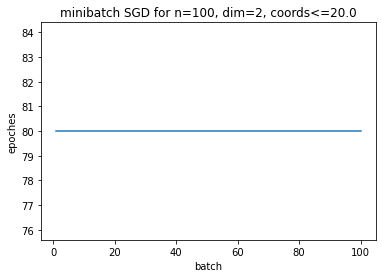

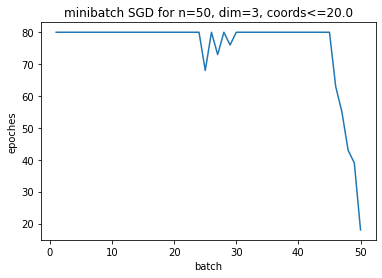

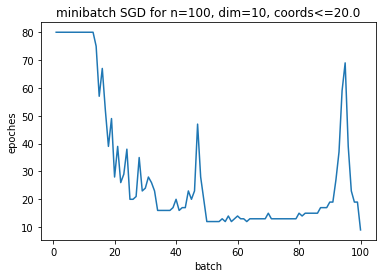

In [98]:
print_batch_size_analyze(input_2d)
print_batch_size_analyze(input_3d)
print_batch_size_analyze(input_large)

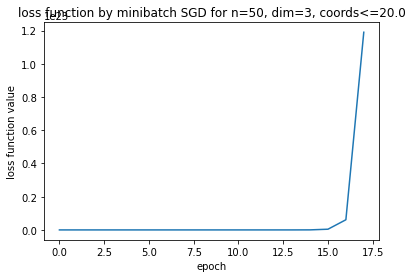

In [99]:
print_loss_function_epochs(input_3d, 50, lr=step_decay)

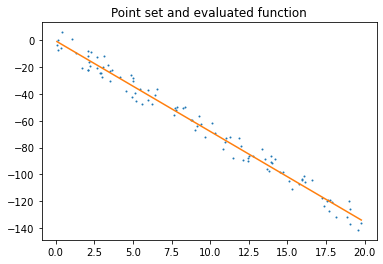

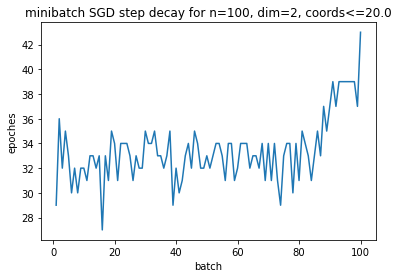

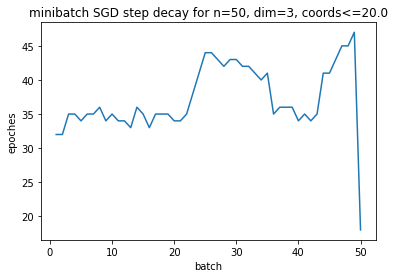

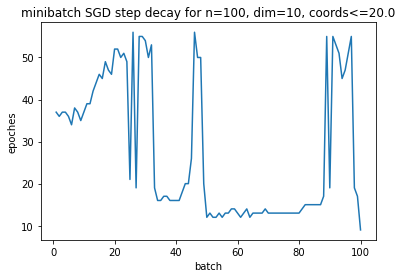

In [100]:
print_2d_result(input_2d, lr = step_decay, current_lr = DEFAULT_LR, gd = sgd)
print_batch_size_analyze(input_2d, step_decay, current_lr = DEFAULT_LR,  name = "minibatch SGD step decay")
print_batch_size_analyze(input_3d, step_decay, current_lr = DEFAULT_LR, name = "minibatch SGD step decay")
print_batch_size_analyze(input_large, step_decay, current_lr = DEFAULT_LR, name = "minibatch SGD step decay")

# Пункт 2. Исследовать влияние предварительной нормализации данных на сходимость

Рассмотрим scaling к диапазону [0, 1]

In [101]:
# check if all coords are scaled
def debug_check_scaling(points, l, r):
    ok = 1
    for i in range(0, points.n):    
        for k in range(0, points.dim - 1):
            ok = ok & (l <= points.x[i][k] <= r)
        ok = ok & (l <= points.y[i] <= r)
    return ok

# call sgd with each possible batch_size for point_set & scaled_point_set
# lr - function (current_lr, epoch)
def scaling_batch_size_compare(points, lr = constant_lr, current_lr = DEFAULT_LR, name = "minibatch SGD"):
    epoches_points = batch_size_analyze(points, lr, current_lr)
    plt.plot(np.linspace(1, len(epoches_points), len(epoches_points)), epoches_points, label='original point set', color='red')
    
    scaled_points = points
    scaled_points = apply_scaling(scaled_points)
    print("check scaling: " + str(debug_check_scaling(scaled_points, 0, 1)))
    epoches_points = batch_size_analyze(scaled_points, lr, current_lr)
    plt.plot(np.linspace(1, len(epoches_points), len(epoches_points)), epoches_points, label='scaled [0; 1] point set', color='blue')
    
    
    plt.xlabel("batch")
    plt.ylabel("epoches")
    plt.title(name + " for n=" + str(points.n) + ", dim=" + str(points.dim) + ", coords<=" + str(points.coords_bound))
    plt.legend()
    plt.show()

In [102]:
# scale all point_set coords into [0; 1] interval
def apply_scaling(points):
    x = points.x.copy()
    y = points.y.copy()
    for k in range(0, points.dim - 1):
        coords = np.asarray([])
        for i in range(0, points.n):
            coords = np.append(coords, points.x[i][k])
        coords = scale_dim(coords)[0]
        for i in range(0, points.n):
            x[i][k] = coords[i]
    y = scale_dim(y)[0] 
    return point_set(points.n, points.dim, x, y, 1)

### Набор точек до скалинга и после

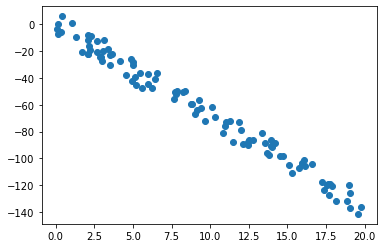

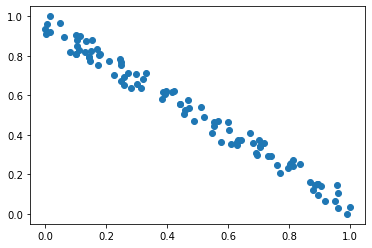

In [103]:
points = input_2d
points_scaling = apply_scaling(points)

ax = plt.figure().add_subplot()
ax.plot(points.x, points.y, 'o')

ax = plt.figure().add_subplot()
ax.plot(points_scaling.x, points_scaling.y, 'o')



### Сходимость со скалингом

check scaling: 1


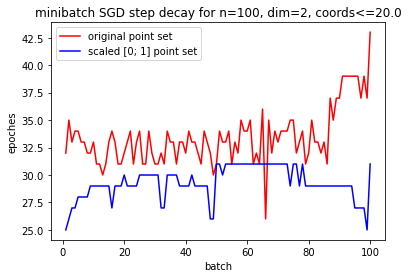

check scaling: 1


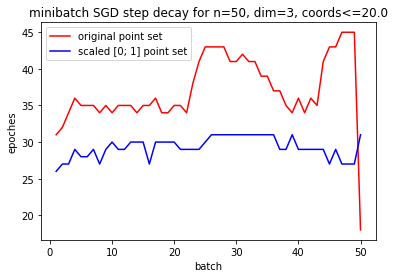

check scaling: 1


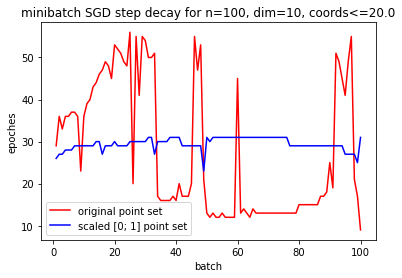

In [104]:
scaling_batch_size_compare(input_2d, step_decay, current_lr = DEFAULT_LR, name = "minibatch SGD step decay")
scaling_batch_size_compare(input_3d, step_decay, current_lr = DEFAULT_LR, name = "minibatch SGD step decay")
scaling_batch_size_compare(input_large, step_decay, current_lr = DEFAULT_LR, name = "minibatch SGD step decay")

# Пункт 3. Исследовать модификации градиентного спуска

### SGD with momentum

In [105]:
# stochastic gradient descent with momentum
#   point - point_set
#   batch_size - amount of variables for diff in one epoch
#   gradinet_supplier - :)
#   starting_coeffs - array of point.dim len
#   lr - function (current_lr, epoch)
#   eps - :)
#   epoches - max amount of epoches
#   betta - parameter
# ret:
#   [
#       found coeffs - array of point.dim len,
#       history - array of all epoches changes
#   ]
def sgd_with_momentum(points, batch_size, gradinet_supplier, starting_coeffs, lr, current_lr, eps, epoches, betta, param_2):
    history = list()
    order = np.asarray(range(0, points.n))
    np.random.shuffle(order)

    coeffs = starting_coeffs
    grad = np.asarray([0] * points.dim)
    batch_index = 0
    
    for i in range(0, epoches):
        to = min(batch_index + batch_size, len(order))
        current_lr = lr(current_lr, i)
        grad = betta * grad + (1 - betta) * gradinet_supplier(points, order[batch_index:to], coeffs)
        coeffs_step = coeffs - current_lr * grad
        
        if LA.norm(coeffs_step - coeffs) <= eps:
            break
        
        history.append(coeffs)
        coeffs = coeffs_step
        
        if to == len(order):
            batch_index = 0
            np.random.shuffle(order)
        else:
            batch_index = to

    return [coeffs, history]

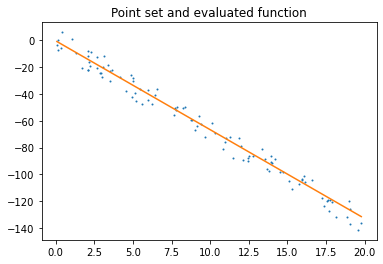

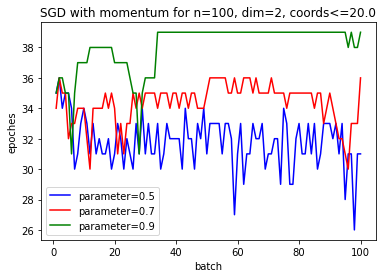

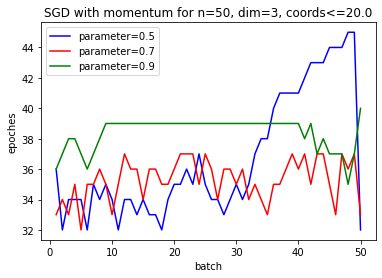

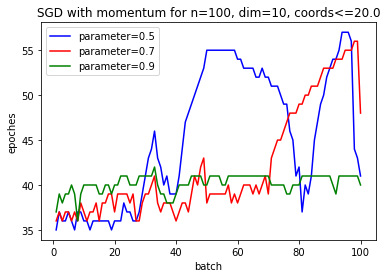

In [106]:
print_2d_result(input_2d, lr = step_decay, current_lr = DEFAULT_LR, gd = sgd_with_momentum, param_1 = 0.7)
print_batch_size_analyze(input_2d, lr = step_decay, gd=sgd_with_momentum, name='SGD with momentum', params_1=[0.5, 0.7, 0.9])
print_batch_size_analyze(input_3d, lr = step_decay, gd=sgd_with_momentum, name='SGD with momentum', params_1=[0.5, 0.7, 0.9])
print_batch_size_analyze(input_large, lr = step_decay, gd=sgd_with_momentum, name='SGD with momentum', params_1=[0.5, 0.7, 0.9])


### SGD with Nesterov momentum

In [107]:
# calculate gradient [d/da, d/db] of loss function for points_set by variables x_i, where i in ids
#   points - point_set
#   ids - array of indices for taking gradient
#   coeffs - current loss function = [a_0, ..., a_k-2, b]
#   betta - parameter
#   grad - previous step gradined
def nesterov_loss_function_grad(points, ids, coeffs, betta, grad):
    result = np.asarray([0.] * points.dim)
    for i in ids:
        result += gradient_compute(points, coeffs - betta * grad, i)
    return result

# stochastic gradient descent with Nesterov momentum
#   point - point_set
#   batch_size - amount of variables for diff in one epoch
#   _gradinet_supplier - ignored
#   starting_coeffs - array of point.dim len
#   lr - function (current_lr, epoch)
#   eps - :)
#   epoches - max amount of epoches
#   betta - parameter
# ret:
#   [
#       found coeffs - array of point.dim len,
#       history - array of all epoches changes
#   ]
def sgd_with_nesterov_momentum(points, batch_size, _gradinet_supplier, starting_coeffs, lr, current_lr, eps, epoches, betta, gamma):
    history = list()
    order = np.asarray(range(0, points.n))
    np.random.shuffle(order)

    coeffs = starting_coeffs
    grad = np.asarray([0] * points.dim)
    batch_index = 0

    for i in range(0, epoches):
        to = min(batch_index + batch_size, len(order))
        current_lr = lr(current_lr, i)
        grad = betta * grad + current_lr * nesterov_loss_function_grad(points, order[batch_index:to], coeffs, betta, grad)
        coeffs_step = coeffs - grad
        
        if LA.norm(coeffs_step - coeffs) <= eps:
            break
        
        history.append(coeffs)
        coeffs = coeffs_step
        
        if to == len(order):
            batch_index = 0
            np.random.shuffle(order)
        else:
            batch_index = to

    return [coeffs, history]

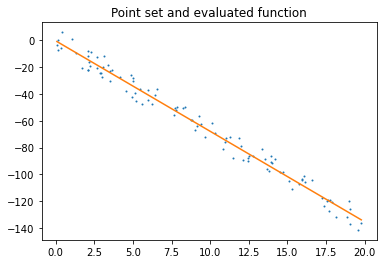

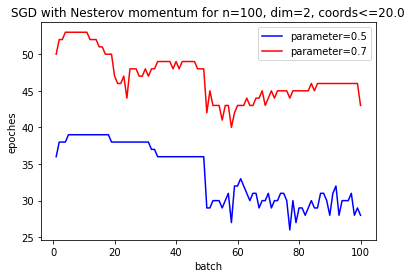

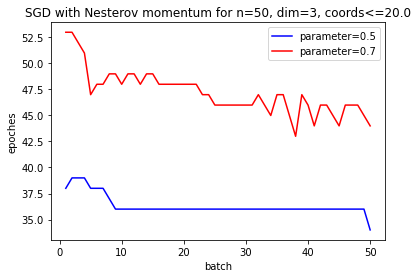

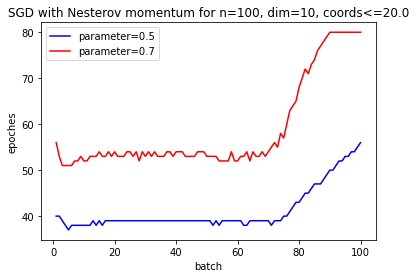

In [108]:
print_2d_result(input_2d, lr = step_decay, current_lr = 0.001, gd = sgd_with_nesterov_momentum, param_1 = 0.5)
print_batch_size_analyze(input_2d, lr = step_decay, current_lr = 0.001, gd = sgd_with_nesterov_momentum, name = 'SGD with Nesterov momentum', params_1 = [0.5, 0.7])
print_batch_size_analyze(input_3d, lr = step_decay, current_lr = 0.001, gd = sgd_with_nesterov_momentum, name = 'SGD with Nesterov momentum', params_1 = [0.5, 0.7])
print_batch_size_analyze(input_large, lr = step_decay, current_lr = 0.001, gd = sgd_with_nesterov_momentum, name = 'SGD with Nesterov momentum', params_1 = [0.5, 0.7])

### ADA GRAD

In [109]:
def adagrad(points, batch_size, gradinet_supplier, starting_coeffs, lr, current_lr, eps, epoches, betta, gamma):
    history = list()
    order = np.asarray(range(0, points.n))
    np.random.shuffle(order)

    batch_index = 0
    coeffs = starting_coeffs
    grad = np.asarray([0] * points.dim)
    prev_v= np.asarray([0] * points.dim)
    
    
    for i in range(0, epoches):
        to = min(batch_index + batch_size, len(order))
        current_lr = lr(current_lr, i)
        grad = gradinet_supplier(points, order[batch_index:to], coeffs)
        v = prev_v + np.power(grad, 2)
        coeffs_step = coeffs - np.divide(grad, np.power(v, 0.5))*current_lr
        
        if LA.norm(coeffs_step - coeffs) <= eps:
            break
        
        history.append(coeffs)
        coeffs = coeffs_step
        prev_v = v
        
        if to == len(order):
            batch_index = 0
            np.random.shuffle(order)
        else:
            batch_index = to

    return [coeffs, history]

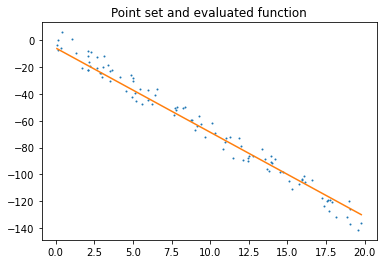

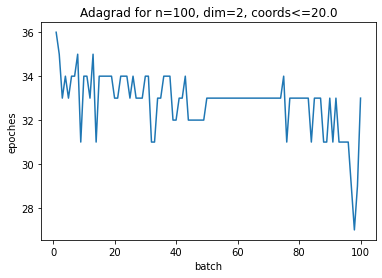

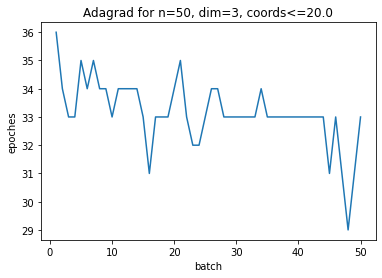

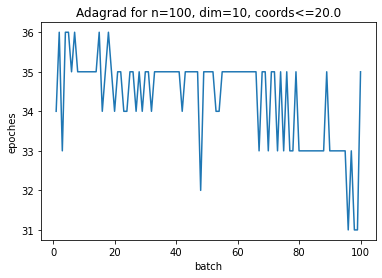

In [110]:
print_2d_result(input_2d, lr = step_decay, current_lr = 2, gd = adagrad)
print_batch_size_analyze(input_2d, lr = step_decay, current_lr = 2, gd = adagrad, name = 'Adagrad')
print_batch_size_analyze(input_3d, lr = step_decay, current_lr = 2, gd = adagrad, name = 'Adagrad')
print_batch_size_analyze(input_large, lr = step_decay, current_lr = 2, gd = adagrad, name = 'Adagrad')

### RMS Prop

In [111]:
def rms_prop(points, batch_size, gradinet_supplier, starting_coeffs, lr, current_lr, eps, epoches, betta, gamma):
    history = list()
    order = np.asarray(range(0, points.n))
    np.random.shuffle(order)

    batch_index = 0
    coeffs = starting_coeffs
    grad = np.asarray([0] * points.dim)
    prev_v= np.asarray([0] * points.dim)
    
    
    for i in range(0, epoches):
        to = min(batch_index + batch_size, len(order))
        current_lr = lr(current_lr, i)
        grad = gradinet_supplier(points, order[batch_index:to], coeffs)
        v = prev_v * betta + (1 - betta) * np.power(grad, 2)
        coeffs_step = coeffs - np.divide(grad, np.power(v, 0.5))*current_lr
        
        if LA.norm(coeffs_step - coeffs) <= eps:
            break
        
        history.append(coeffs)
        coeffs = coeffs_step
        prev_v = v
        
        if to == len(order):
            batch_index = 0
            np.random.shuffle(order)
        else:
            batch_index = to

    return [coeffs, history]

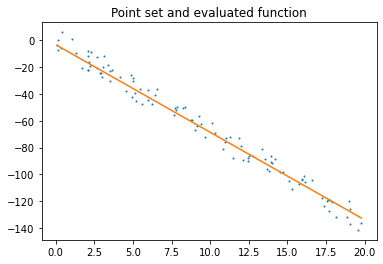

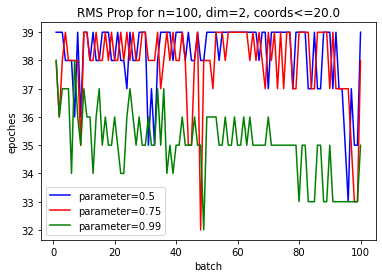

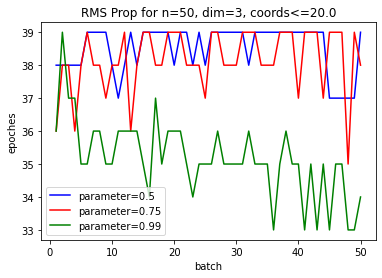

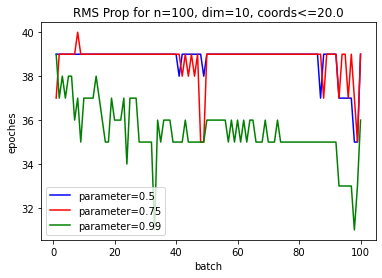

In [112]:
print_2d_result(input_2d, lr = step_decay, current_lr = 1, gd = rms_prop, param_1 = 0.99)
print_batch_size_analyze(input_2d, lr = step_decay, current_lr = 1, gd=rms_prop, name='RMS Prop', params_1=[0.5, 0.75, 0.99])
print_batch_size_analyze(input_3d, lr = step_decay, current_lr = 1, gd=rms_prop, name='RMS Prop', params_1=[0.5, 0.75, 0.99])
print_batch_size_analyze(input_large, lr = step_decay, current_lr = 1, gd=rms_prop, name='RMS Prop', params_1=[0.5, 0.75, 0.99])

### ADAM

In [113]:
def adam(points, batch_size, gradinet_supplier, starting_coeffs, lr, current_lr, eps, epoches, betta, gamma):
    history = list()
    order = np.asarray(range(0, points.n))
    np.random.shuffle(order)

    batch_index = 0
    coeffs = starting_coeffs
    prev_grad = np.asarray([0] * points.dim)
    prev_v= np.asarray([0] * points.dim)
    epsilon = np.asarray([0.1] * points.dim)
    
    
    for i in range(0, epoches):
        to = min(batch_index + batch_size, len(order))
        current_lr = lr(current_lr, i)
        
        grad = gradinet_supplier(points, order[batch_index:to], coeffs)
        
        grad_current = betta * prev_grad + (1-betta) * grad
        v = prev_v*gamma + (1-gamma)*np.power(grad, 2)

        coeffs_step = coeffs - np.divide(grad_current, (np.power(v, 0.5) + epsilon))*current_lr
        
        if LA.norm(coeffs_step - coeffs) <= eps:
            break
        
        history.append(coeffs)
        coeffs = coeffs_step
        prev_v = v
        prev_grad = grad_current
        
        if to == len(order):
            batch_index = 0
            np.random.shuffle(order)
        else:
            batch_index = to

    return [coeffs, history]


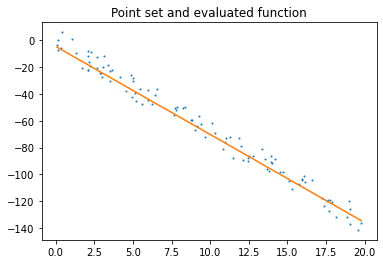

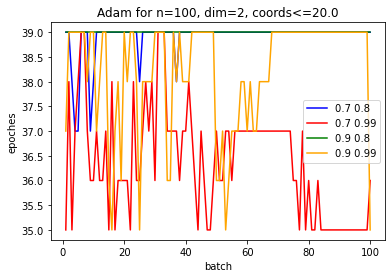

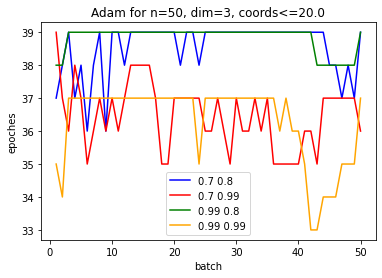

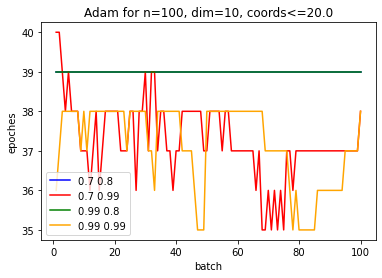

In [117]:
print_2d_result(input_2d, lr = step_decay, current_lr = 1.5, gd = adam, param_1 = 0.9, param_2 = 0.99)
print_batch_size_analyze(input_2d, lr = step_decay, current_lr = 1.5, gd = adam, name = 'Adam', params_1 = [0.7, 0.9], params_2 = [0.8, 0.99])
print_batch_size_analyze(input_3d, lr = step_decay, current_lr = 1.5, gd = adam, name = 'Adam', params_1 = [0.7, 0.99], params_2 = [0.8, 0.99])
print_batch_size_analyze(input_large, lr = step_decay, current_lr = 1.5, gd = adam, name = 'Adam', params_1 = [0.7, 0.99], params_2 = [0.8, 0.99])

# Пункт 4. Сравнить методы

In [118]:
name_function = [adam, rms_prop, adagrad, sgd_with_momentum, sgd_with_nesterov_momentum, sgd]
a_counter= [6, 11, 8, 5, 7, 5]

def call_func(points, batch, lr = step_decay, current_lr = DEFAULT_LR, gd = sgd, param_1 = 0.01, param_2 = 0.1):
    result = gd(points, batch, loss_function_grad, np.asarray([0.] * (points.dim)), lr, current_lr, 1e-6, EPOCH_MAX, param_1, param_2)
    return len(result[1])
    

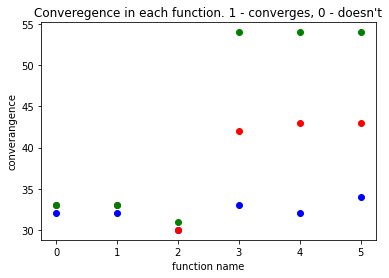

In [119]:
def draw_points_(batch, color, points):
    for i in range(0, len(name_function)):
        res = call_func(points, batch, gd = name_function[i])
        plt.scatter(i, res,  marker="o", color=color)



def print_convergence(draw_points, x_label, y_label, title, batch = 2):
    draw_points(batch, colors[0], input_2d)   
    draw_points(batch, colors[1], input_3d)    
    draw_points(batch, colors[2], input_large)  
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()  

print_convergence(draw_points_, "function name", "converangence", "Converegence in each function. 1 - converges, 0 - doesn't", 30)      

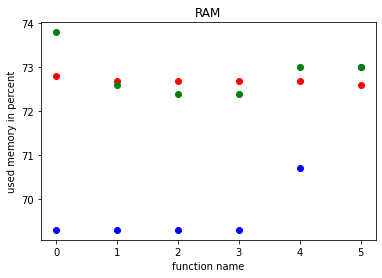

In [120]:
import psutil

def print_points_vir_memory(batch, color, points):
    for i in range(0, len(name_function)):
        batch_size_analyze(points, step_decay, gd = name_function[i])
        res = psutil.virtual_memory()[2]
        plt.scatter(i,res, marker="o", color=color)


print_convergence(print_points_vir_memory, "function name", "used memory in percent", "RAM")


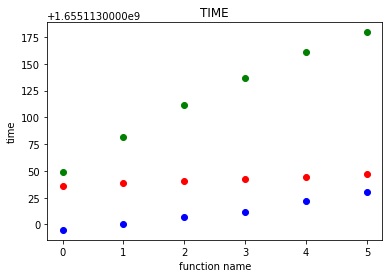

In [121]:
import time

def print_points_time(batch, color, points):
    for i in range(0, len(name_function)):
        startTime = time.time() 
        batch_size_analyze(points, step_decay, gd = name_function[i])
        lastTime = startTime
        plt.scatter(i, lastTime, marker="o", color=color)

print_convergence(print_points_time, "function name", "time", "TIME")

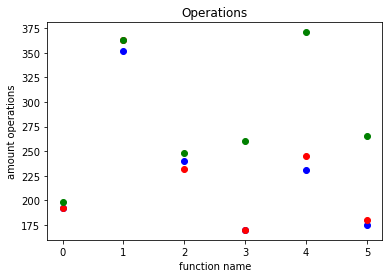

In [122]:
def print_points_operations(batch, color, points):
    for i in range(0, len(name_function)):
        res = call_func(points, batch, gd = name_function[i])
        plt.scatter(i, res*a_counter[i], marker="o", color=color)


print_convergence(print_points_operations, "function name","amount operations", "Operations", 20)

# Пункт 5. Построить траекторию спуска

In [123]:
def line_of_levels(points, batch = 2, lr = constant_lr, current_lr = DEFAULT_LR, gd = sgd, param_1 = 0.1, param_2 = 0.1):
    fig, ax = plt.subplots()

    result = gd(points, batch, loss_function_grad, np.asarray([0.] * (points.dim)), lr, current_lr, 1e-6, EPOCH_MAX, param_1, param_2)[1]

    min_point = result[-1]

    repoints = np.asarray(result).reshape(-1, 2)

    offset = np.max(min_point) * 15

    x = np.linspace(min_point[0] - offset, min_point[0] + offset, 150)
    y = np.linspace(min_point[1] - offset, min_point[1] + offset, 150)
    xgrid, ygrid = np.meshgrid(x,y)

    test = xgrid.copy()

    for i in range(x.size):
      for j in range(y.size):
        test[i][j] = apply_all_loss_functions(points, [xgrid[i][j], ygrid[i][j]])


    ax.plot(repoints[:, 0], repoints[:, 1], 'o-')
    ax.contour(xgrid, ygrid, test, levels=sorted([apply_all_loss_functions(points, p) for p in repoints]))
    plt.show()

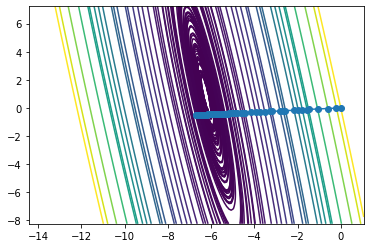

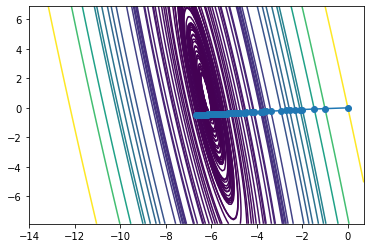

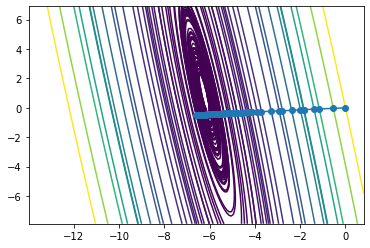

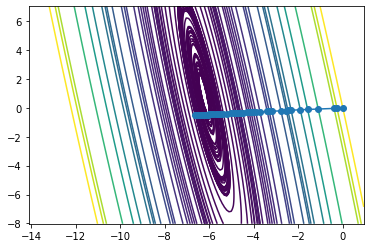

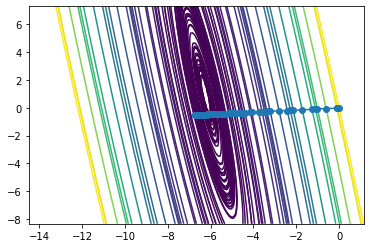

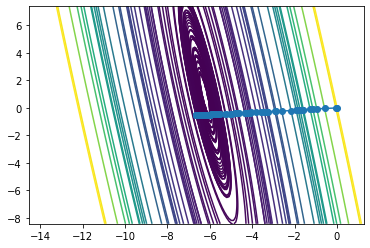

In [124]:
def print_line_of_levels(points):
    for i in range(0, len(name_function)):
        line_of_levels(points)

print_line_of_levels(input_2d)